In [1]:
# Name: Arooba Hanif
# Roll Number: Ezi-ML-B1-227
# Shift Time: Remote
# Internship Type: Hybird/Remote

# TASK 09

In [2]:
# Project 9: Convolutional Neural Network (CNN) for CIFAR-10 Image Classification
# Goal: Build, train and evaluate a CNN on CIFAR-10 with data augmentation and visualize feature-maps.
# Deliverables: training/validation plots, test accuracy, and feature map visualizations.

In [3]:
# Imports & GPU check
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Reproducibility (best-effort)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs found:", gpus)


GPUs found: []


In [4]:
# Load CIFAR-10, inspect shapes and classes
# Load CIFAR-10 (built-in)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("x_train shape:", x_train.shape)   # (50000, 32, 32, 3)
print("y_train shape:", y_train.shape)   # (50000, 1)
print("x_test shape:", x_test.shape)     # (10000, 32, 32, 3)

# Class names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)


/tmp/ipython-input-1343042240.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y_train[i])])


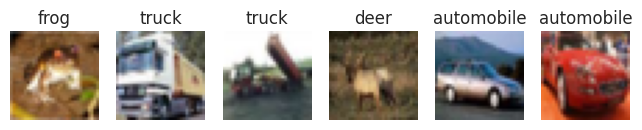

In [5]:
# Preprocess: normalization and one-hot labels
# Normalize images to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

# One-hot encode labels
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

# Quick visual check (show 6 images)
plt.figure(figsize=(8,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[int(y_train[i])])
    plt.axis('off')
plt.show()


In [6]:
# Data augmentation (ImageDataGenerator)
# Data augmentation for training set
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.1  # we'll use 10% of train for validation
)

# We will use datagen.flow for training with subset
BATCH_SIZE = 64

train_generator = datagen.flow(
    x_train, y_train_cat,
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = datagen.flow(
    x_train, y_train_cat,
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False,
    seed=SEED
)

print("Train batches per epoch:", len(train_generator))
print("Validation batches per epoch:", len(val_generator))


Train batches per epoch: 704
Validation batches per epoch: 79


In [7]:
# Build CNN model (clean, moderately deep)
def build_cnn(input_shape=(32,32,3), num_classes=10):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    # Block 2
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    # Block 3
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    # Classification head
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_cnn()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,196,970 (4.57 MB)

 Trainable params: 1,195,306 (4.56 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [8]:
# Callbacks & train the model (with augmentation)
# Callbacks
checkpoint = ModelCheckpoint("best_cifar10.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop  = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

EPOCHS = 10  # change to lower (e.g., 10) for quick testing

history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    epochs = EPOCHS,
    callbacks = [checkpoint, earlystop, reduce_lr],
    verbose = 1
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.3443 - loss: 2.1536
Epoch 1: val_accuracy improved from -inf to 0.43940, saving model to best_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 355s 491ms/step - accuracy: 0.3444 - loss: 2.1531 - val_accuracy: 0.4394 - val_loss: 1.6865 - learning_rate: 0.0010
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.5285 - loss: 1.3140
Epoch 2: val_accuracy improved from 0.43940 to 0.58420, saving model to best_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 386s 499ms/step - accuracy: 0.5286 - loss: 1.3139 - val_accuracy: 0.5842 - val_loss: 1.1544 - learning_rate: 0.0010
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.6029 - loss: 1.1248
Epoch 3: val_accuracy improved from 0.58420 to 0.60520, saving model to best_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 341s 484ms/step - accuracy: 0.6029 - loss: 1.1247 - val_accuracy: 0.6052 - val_loss: 1.1322 - learning_rate: 0.0010
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6394 - loss: 1.0121
Epoch 4: val_accuracy improved from 0.60520 to 0.66820, saving model to best_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 379s 480ms/step - accuracy: 0.6394 - loss: 1.0121 - val_accuracy: 0.6682 - val_loss: 0.9587 - learning_rate: 0.0010
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6664 - loss: 0.9488
Epoch 5: val_accuracy improved from 0.66820 to 0.70620, saving model to best_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 344s 488ms/step - accuracy: 0.6664 - loss: 0.9488 - val_accuracy: 0.7062 - val_loss: 0.8221 - learning_rate: 0.0010
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6865 - loss: 0.8845
Epoch 6: val_accuracy improved from 0.70620 to 0.71420, saving model to best_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 346s 491ms/step - accuracy: 0.6865 - loss: 0.8845 - val_accuracy: 0.7142 - val_loss: 0.8058 - learning_rate: 0.0010
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7017 - loss: 0.8477
Epoch 7: val_accuracy did not improve from 0.71420
704/704 ━━━━━━━━━━━━━━━━━━━━ 338s 480ms/step - accuracy: 0.7017 - loss: 0.8477 - val_accuracy: 0.7128 - val_loss: 0.8308 - learning_rate: 0.0010
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.7110 - loss: 0.8248
Epoch 8: val_accuracy improved from 0.71420 to 0.73060, saving model to best_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 374s 469ms/step - accuracy: 0.7110 - loss: 0.8248 - val_accuracy: 0.7306 - val_loss: 0.8690 - learning_rate: 0.0010
Epoch 9/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7224 - loss: 0.8010
Epoch 9: val_accuracy improved from 0.73060 to 0.75240, saving model to best_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 327s 465ms/step - accuracy: 0.7224 - loss: 0.8010 - val_accuracy: 0.7524 - val_loss: 0.7162 - learning_rate: 0.0010
Epoch 10/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7320 - loss: 0.7682
Epoch 10: val_accuracy improved from 0.75240 to 0.77040, saving model to best_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 383s 466ms/step - accuracy: 0.7320 - loss: 0.7682 - val_accuracy: 0.7704 - val_loss: 0.6536 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 10.


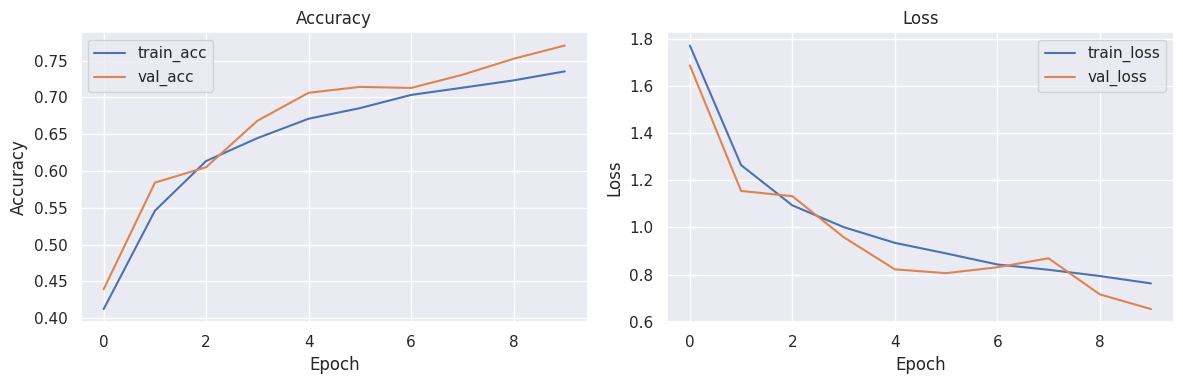

In [9]:
# Plot training history (accuracy & loss)
# Plot accuracy and loss
def plot_history(hist):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Accuracy'); plt.legend(); plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Loss'); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)


313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.7583 - loss: 0.7300
Test accuracy: 0.7572, Test loss: 0.7276
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane     0.8158    0.7840    0.7996      1000
  automobile     0.8699    0.9290    0.8985      1000
        bird     0.8155    0.5790    0.6772      1000
         cat     0.6941    0.4810    0.5682      1000
        deer     0.7707    0.6690    0.7163      1000
         dog     0.8277    0.5430    0.6558      1000
        frog     0.5767    0.9470    0.7169      1000
       horse     0.8080    0.8330    0.8203      1000
        ship     0.7763    0.9060    0.8362      1000
       truck     0.7483    0.9010    0.8176      1000

    accuracy                         0.7572     10000
   macro avg     0.7703    0.7572    0.7506     10000
weighted avg     0.7703    0.7572    0.7506     10000



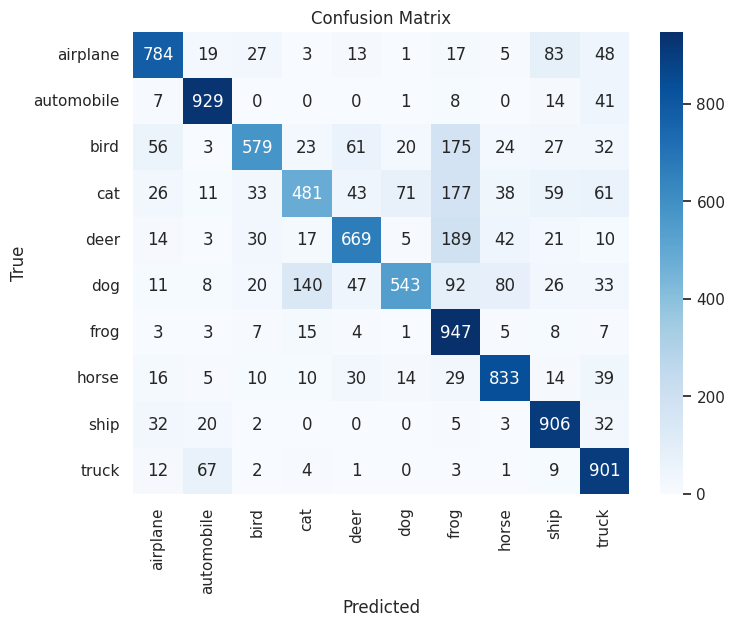

In [10]:
# Evaluate on test set & classification report
# Load best model if exists
if os.path.exists("best_cifar10.h5"):
    model.load_weights("best_cifar10.h5")

test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=1)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

# Predictions for confusion matrix / classification report
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


/tmp/ipython-input-4077871631.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {class_names[int(y_test[idx])]}\nPred: {class_names[y_pred[idx]]}")


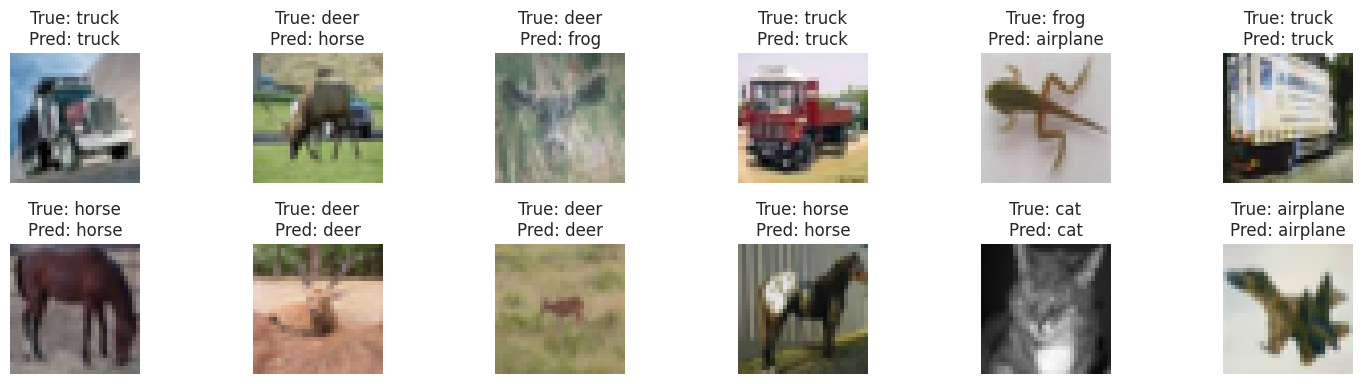

In [11]:
# Visualize some test predictions (images + pred vs true)
# Show some test images with predictions
n = 12
plt.figure(figsize=(15,4))
indices = np.random.choice(len(x_test), n, replace=False)
for i, idx in enumerate(indices):
    plt.subplot(2,6,i+1)
    plt.imshow(x_test[idx])
    plt.title(f"True: {class_names[int(y_test[idx])]}\nPred: {class_names[y_pred[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [12]:
# Force a forward pass to "build" the model
_ = model.predict(x_test[:1])
print(" Model has now been called once.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
 Model has now been called once.


In [13]:
from tensorflow.keras import Model, layers

# Build functional model using the called Sequential model
input_tensor = layers.Input(shape=(32, 32, 3))
output_tensor = model(input_tensor)  # force forward pass
functional_model = Model(inputs=input_tensor, outputs=output_tensor)

print(" Functional model created successfully.")


 Functional model created successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
 Model is built.
 Extracted feature maps from layer: conv2d, shape: (1, 32, 32, 32)


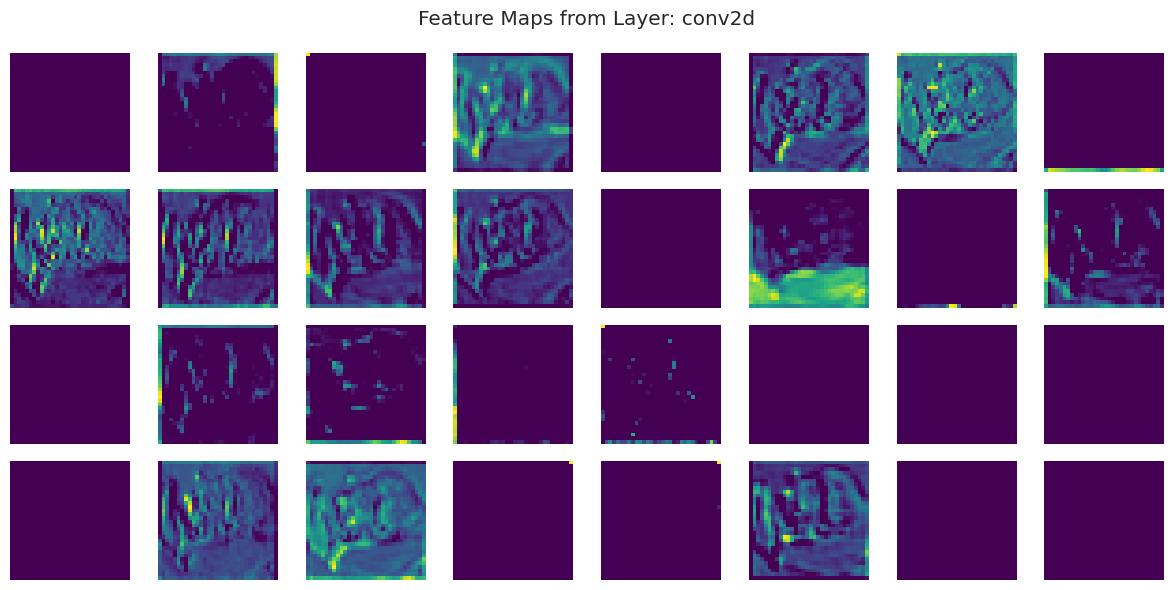

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

#  STEP 1: Ensure model is built
_ = model.predict(x_test[:1])
print(" Model is built.")

#  STEP 2: Select an image
sample_img = x_test[0][np.newaxis, ...]  # Add batch dimension

#  STEP 3: Forward pass through outer model
x = sample_img
selected_layer_name = None

for i, layer in enumerate(model.layers):  #  Directly iterate outer model layers
    x = layer(x)  # forward pass
    if isinstance(layer, layers.Conv2D) and selected_layer_name is None:
        selected_layer_name = layer.name
        feature_maps = x.numpy()  # convert to numpy
        break

if selected_layer_name is None:
    raise ValueError(" No Conv2D layer found in model!")

print(f" Extracted feature maps from layer: {selected_layer_name}, shape: {feature_maps.shape}")

#  STEP 4: Plot first 64 feature maps
n_features = feature_maps.shape[-1]
n_cols = 8
n_rows = int(np.ceil(min(n_features, 64) / n_cols))

plt.figure(figsize=(n_cols*1.5, n_rows*1.5))
for i in range(min(n_features, 64)):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(feature_maps[0, :, :, i], cmap="viridis")
    plt.axis("off")
plt.suptitle(f"Feature Maps from Layer: {selected_layer_name}")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
 Model is built.
 Extracted feature maps from layer: conv2d, shape: (1, 32, 32, 32)


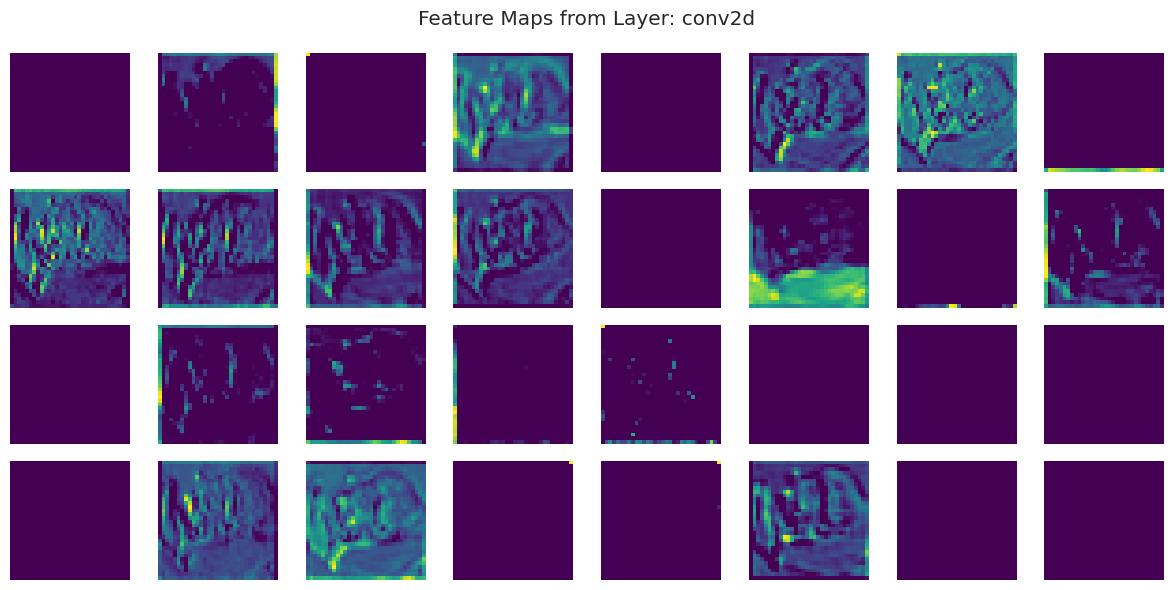

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

def extract_first_conv_features(model, sample_img):
    """
    Universal function to extract first Conv2D layer feature maps
    from Sequential / Functional / nested Sequential models.
    """
    # 🔧 Ensure model is built
    _ = model.predict(sample_img[:1])
    print(" Model is built.")

    # 🔧 Function to recursively iterate layers
    def get_layers(layers_list):
        flat_layers = []
        for layer in layers_list:
            if hasattr(layer, "layers"):  # nested Sequential or Functional
                flat_layers.extend(get_layers(layer.layers))
            else:
                flat_layers.append(layer)
        return flat_layers

    # Get all inner layers
    all_layers = get_layers(model.layers)

    #  Forward pass manually
    x = sample_img
    selected_layer_name = None
    feature_maps = None

    for layer in all_layers:
        x = layer(x)  # forward pass through layer
        if isinstance(layer, layers.Conv2D) and selected_layer_name is None:
            selected_layer_name = layer.name
            feature_maps = x.numpy()
            break

    if selected_layer_name is None:
        raise ValueError(" No Conv2D layer found in model!")

    print(f" Extracted feature maps from layer: {selected_layer_name}, shape: {feature_maps.shape}")
    return feature_maps, selected_layer_name


# ------------------ USING FUNCTION ------------------

# Pick one image
sample_img = x_test[0][np.newaxis, ...]  # shape (1, 32, 32, 3)

# Extract feature maps
feature_maps, selected_layer_name = extract_first_conv_features(model, sample_img)

#  Plot first 64 feature maps
n_features = feature_maps.shape[-1]
n_cols = 8
n_rows = int(np.ceil(min(n_features, 64) / n_cols))

plt.figure(figsize=(n_cols*1.5, n_rows*1.5))
for i in range(min(n_features, 64)):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(feature_maps[0, :, :, i], cmap="viridis")
    plt.axis("off")
plt.suptitle(f"Feature Maps from Layer: {selected_layer_name}")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
 Model is built.
 Extracting feature maps from Conv2D layer 0: conv2d
 Feature maps shape: (1, 32, 32, 32)


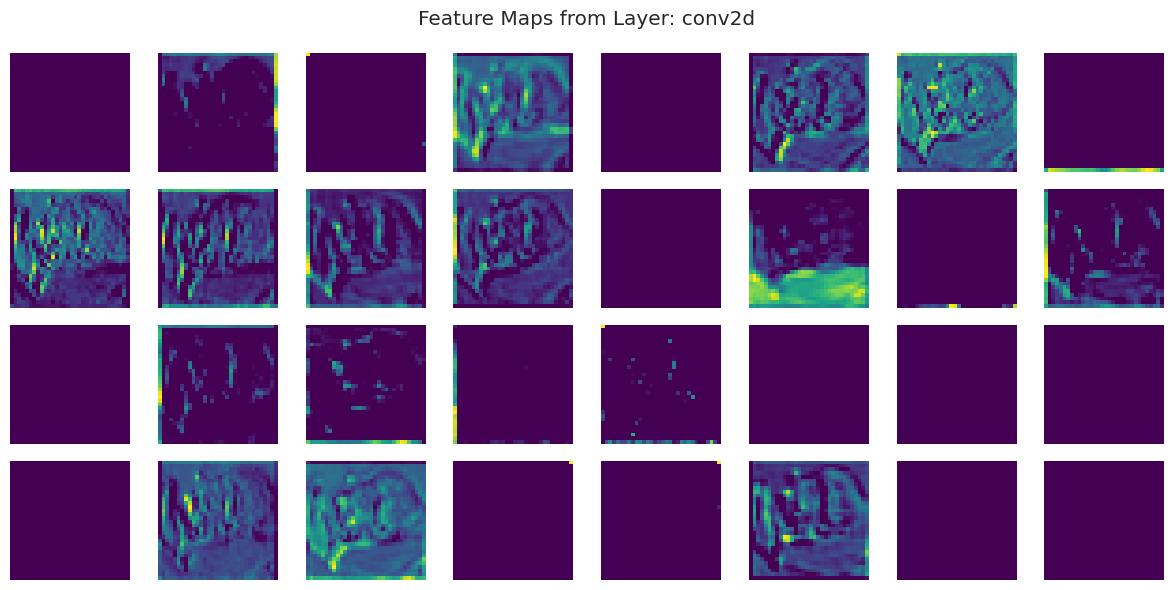

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

def extract_conv_features(model, sample_img, layer_index=0):
    """
    Extract feature maps from nth Conv2D layer in model.
    layer_index = 0 -> first Conv2D layer
    layer_index = 1 -> second Conv2D layer
    """
    # 🔧 Ensure model is built
    _ = model.predict(sample_img[:1])
    print(" Model is built.")

    # 🔧 Flatten all layers (Sequential + nested + Functional)
    def get_layers(layers_list):
        flat_layers = []
        for layer in layers_list:
            if hasattr(layer, "layers"):  # nested Sequential/Functional
                flat_layers.extend(get_layers(layer.layers))
            else:
                flat_layers.append(layer)
        return flat_layers

    all_layers = get_layers(model.layers)

    #  Collect all Conv2D layers
    conv_layers = [layer for layer in all_layers if isinstance(layer, layers.Conv2D)]
    if not conv_layers:
        raise ValueError(" No Conv2D layers found in model!")

    if layer_index >= len(conv_layers):
        raise IndexError(f" Model has only {len(conv_layers)} Conv2D layers, you asked for index {layer_index}")

    selected_layer = conv_layers[layer_index]
    print(f" Extracting feature maps from Conv2D layer {layer_index}: {selected_layer.name}")

    #  Forward pass until selected layer
    x = sample_img
    feature_maps = None
    for layer in all_layers:
        x = layer(x)
        if layer == selected_layer:
            feature_maps = x.numpy()
            break

    print(f" Feature maps shape: {feature_maps.shape}")
    return feature_maps, selected_layer.name


# ------------------ USE FUNCTION ------------------

sample_img = x_test[0][np.newaxis, ...]  # single test image

#  Choose which conv layer to visualize (0=first, 1=second...)
feature_maps, selected_layer_name = extract_conv_features(model, sample_img, layer_index=0)

#  Plot feature maps
n_features = feature_maps.shape[-1]
n_cols = 8
n_rows = int(np.ceil(min(n_features, 64) / n_cols))

plt.figure(figsize=(n_cols*1.5, n_rows*1.5))
for i in range(min(n_features, 64)):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(feature_maps[0, :, :, i], cmap="viridis")
    plt.axis("off")
plt.suptitle(f"Feature Maps from Layer: {selected_layer_name}")
plt.tight_layout()
plt.show()


 Saved model as: cifar10_cnn_final.h5


<Figure size 1000x500 with 0 Axes>

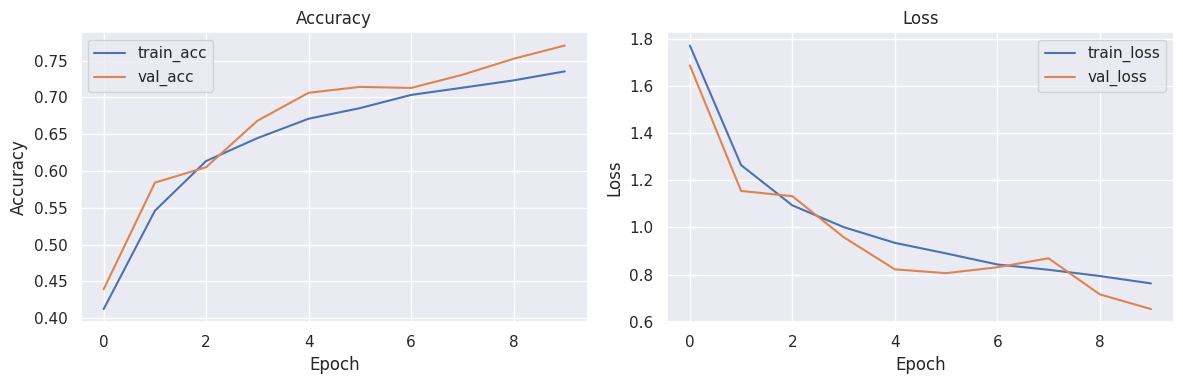

<Figure size 640x480 with 0 Axes>

 Saved training history plot as: training_history.png


In [17]:
#  Save final trained model
model.save("cifar10_cnn_final.h5")
print(" Saved model as: cifar10_cnn_final.h5")

#  Plot and save training history
plt.figure(figsize=(10, 5))
plot_history(history)
plt.savefig("training_history.png", dpi=200, bbox_inches='tight')
plt.show()
print(" Saved training history plot as: training_history.png")
